# Project 02 - Image segmentation and object detection

In this project, we would like you to investigate image segmentation and object detection.
For this, you will use the data from the [Broad Bioimage Benchmark Collection](https://bbbc.broadinstitute.org/BBBC039).
The dataset contains images of cells acquired using fluorescence microscopy, along with annotations of individual cells.
Your goal will be to apply the segmentation and detection methods described in the lecture to the dataset.

__Note:__ The main goal of this project to get you working on a real-world segmentation/detection task. Projects will not be graded based on the performance of the trained classifiers.

![A stack of images](./broad_dataset.png)

We suggest that you follow the following  steps:
1. __Know your data__ Have a look  at the resources provided on the website to understand the dataset.
1. Download and inspect the images, groundtruth annotations, and metadata. Plot a few example datapoints. __Tip:__ The data has fixed URLs, so you can download the data from within the notebook (e.g., using `!wget URL`).
1. Write a data loader that allows you to use the data in PyTorch. Split the data according to the training, test, and validation files provided in the metadata.
1. Train one or multiple of the segmentation models discussed in the lecture (or any other segmentation model you would like to try) to segment the cells. Report the loss curve, appropriate quality metrics, and some example results of the trained model(s).
1. Train one of multiple of the detection models discussed in the lecture (or any other detection method you would like to try) to detect the cells. Report the loss curve, appropriate quality metrics, and some example results of the trained model(s).

Tipps and hints:
1. Please do not add the dataset to your submission. Use `.gitignore` to ignore the directory containing the downloaded dataset.
1. Think about how you have to process the provided groundtruth data to make it usable for segmentation and detection.
1. `scikit-image` provides several helpful functions for extracting information from masks. Have a look at `skimage.measure.label` and `skimage.measure.regionprops`. These can help to convert data into a format that is appropriate for detection.

In [ ]:
# !wget -q -N https://data.broadinstitute.org/bbbc/BBBC039/images.zip
# !wget -q -N https://data.broadinstitute.org/bbbc/BBBC039/masks.zip
# !wget -q -N https://data.broadinstitute.org/bbbc/BBBC039/metadata.zip

In [ ]:
# !mkdir dataset
# !unzip -q -o '*.zip' -d dataset
# !rm -r /content/dataset/__MACOSX

In [ ]:
!pip install -U -q albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 4.1 MB/s eta 0:00:00


In [ ]:
!pip install -q torchmetrics
from torchmetrics.classification import MulticlassJaccardIndex
from torchmetrics.detection.mean_ap import MeanAveragePrecision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 10.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from pathlib import Path
import skimage.io
import skimage.morphology
import skimage.segmentation
import requests, zipfile, io
import cv2
from skimage import exposure, img_as_ubyte
from skimage.morphology import dilation
from skimage.measure import regionprops
from torch.nn.utils.rnn import pad_sequence
from tqdm.auto import tqdm
from IPython.display import clear_output, display

In [ ]:
import torch
import torch.nn as nn
import albumentations as A
import albumentations.pytorch
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2 as FasterRCNN
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2 as MaskRCNN

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Dataloading and preprocessing

In [ ]:
class BBBC039_Dataset(Dataset):
  def __init__(self, split = 'train', mode = 'binary', download = True):

    #initialize paths
    links = {'images.zip' : 'https://data.broadinstitute.org/bbbc/BBBC039/images.zip',
             'masks.zip': 'https://data.broadinstitute.org/bbbc/BBBC039/masks.zip',
             'metadata.zip': 'https://data.broadinstitute.org/bbbc/BBBC039/metadata.zip'}
    curr_dir = os.getcwd()
    DATASET_DIR = curr_dir+'/dataset'
    metadata_path = DATASET_DIR+'/metadata/'
    imgdata_path = DATASET_DIR+'/images/'
    maskdata_path = DATASET_DIR+'/masks/'
    download = not os.path.exists('./dataset') if download else download
    #download and extract data
    for filename, link in links.items():
      if download:
        r = requests.get(link)
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall(DATASET_DIR)

    test_names = Path(metadata_path+'test.txt').read_text().split('\n')[:-1]
    train_names = Path(metadata_path+'training.txt').read_text().split('\n')[:-1]
    val_names = Path(metadata_path+'validation.txt').read_text().split('\n')[:-1]

    img_names = {'train': train_names,
                 'test': test_names,
                 'val': val_names}

    self.mode = mode
    #cutting images to allow correct Unet downsampling
    #h_cut, w_cut = 512, 640
    #load images
    self.imgs = np.array([img_as_ubyte(exposure.rescale_intensity(skimage.io.imread(imgdata_path+img_name.replace('.png', '.tif')))) for img_name in img_names[split]])
    #load and decode segmentation mask
    mask = [skimage.io.imread(maskdata_path+img_name)[..., 0] for img_name in img_names[split]]
    self.labels = np.array(list(map(skimage.morphology.label, mask)))
    self.labels = skimage.morphology.remove_small_objects(self.labels, min_size= 40)
    #calculate bounding boxes
    region_list = list(map(regionprops, self.labels))
    self.bboxes = np.array([[[region.bbox[1], region.bbox[0], region.bbox[3], region.bbox[2], 1]
                                             for region in regions] for regions in region_list], dtype = object)
    #filter the data
    lens = np.array(list(map(len, self.bboxes)))
    good_ind =  lens != 0
    self.imgs = self.imgs[good_ind]
    self.labels = self.labels[good_ind]
    self.bboxes = self.bboxes[good_ind]
    #binarize segmentation mask
    if mode == 'binary':
      self.labels = np.array(list(map(self.binarize, self.labels)))
    #initialize augmentations
    self.split = split
    self.aug = self.get_transform()

  def binarize(self, img):
    binary = np.zeros_like(img)
    binary[img > 0] = 1
    outer_bound = skimage.segmentation.find_boundaries(img>0, mode = 'outer')
    outer_bound = dilation(outer_bound)
    all_bound = skimage.segmentation.find_boundaries(img, mode = 'outer')
    inner_bound = ~outer_bound & all_bound
    for i in range(2):
      inner_bound = dilation(inner_bound)
    binary[inner_bound & img>0] = 2
    return binary

  def __getitem__(self, ind):
    img, bin_masks, bboxes = self.imgs[ind], self.labels[ind], self.bboxes[ind]
    if self.mode != 'binary':
      # split the color-encoded mask into a set of binary masks
      # instances are encoded as different colors
      obj_ids = np.unique(bin_masks)
      # first id is the background, so remove it
      obj_ids = obj_ids[1:]
      bin_masks = bin_masks == obj_ids[:, None, None]
      bin_masks = list(bin_masks.astype('uint8'))
    elif self.split == 'train':
      elastic = A.ElasticTransform(p=0.7, alpha=55, sigma=7, alpha_affine=25)
      transform = elastic(image=img, mask=bin_masks)
      img, bin_masks = transform['image'], [transform['mask'].astype('int64')]
    else:
      bin_masks = [bin_masks]
    transform = self.aug(image=img, masks=bin_masks, bboxes = bboxes, indices=np.array(list(range(len(bboxes)))))
    img, bboxes = transform['image'], transform['bboxes']
    if self.mode != 'binary':
      masks = np.array(transform['masks'], dtype = object)[transform['indices']]
    else:
      masks = transform['masks']
    labels = [bbox[4] for bbox in bboxes]
    bboxes = [bbox[:4] for bbox in bboxes]
    target = dict(boxes = bboxes, labels = labels, masks = list(masks))
    return img, target

  def get_transform(self):
    h, w = self.imgs[0].shape
    SCALE = 0.25
    h_res, w_res = 448, 448 #int(h*SCALE), int(w*SCALE)
    bbox_params = A.BboxParams(format = 'pascal_voc', min_visibility=0.2, label_fields=['indices'])
    #A.RandomSizedBBoxSafeCrop(h_res, w_res, p = 0.5, erosion_rate=0.6),
    #A.ElasticTransform(p=0.5, alpha=55, sigma=7, alpha_affine=25),
    if self.split == 'train':
      aug = A.Compose([A.VerticalFlip(p=0.5),
                      A.HorizontalFlip(p=0.5),
                      A.GridDistortion(p = 0.5, num_steps = 16, border_mode=cv2.BORDER_CONSTANT, value = 0),
                      A.RandomCrop(h_res, w_res),
                      A.RandomBrightnessContrast(p=1, brightness_limit=0.05, brightness_by_max=False),
                      A.RandomGamma(p=0.5),
                      A.Normalize(0.5, 0.5),
                      A.pytorch.ToTensorV2()
                      ], bbox_params = bbox_params)
    else:
      aug = A.Compose([A.RandomCrop(h_res, w_res),
                       A.Normalize(0.5, 0.5),
                       A.pytorch.ToTensorV2()
                      ], bbox_params = bbox_params)
    return aug

  def __len__(self):
    return len(self.imgs)

In [ ]:
def visualize_bbox(img, bboxes, color=(0, 0, 0), thickness=1):
    """Visualizes a single bounding box on the image"""
    try:
      img = img.numpy().copy()
    except:
      img = img.copy()
      color=(255, 0, 0)
    for bbox in bboxes:
      if len(bbox)>4:
        x_min, y_min, x_max, y_max, _ = bbox
      else:
        x_min, y_min, x_max, y_max = bbox
      cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), color=color, thickness=thickness)
    return img

In [ ]:
DOWNLOAD = True
train_ds = BBBC039_Dataset(download=DOWNLOAD)
val_ds = BBBC039_Dataset(split = 'val', download=False)
test_ds = BBBC039_Dataset(split = 'test', download=False)

In [ ]:
BATCH_SIZE = 8
train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle = True, collate_fn=lambda x:list(zip(*x)))
val_loader = DataLoader(val_ds, BATCH_SIZE, shuffle = True, collate_fn=lambda x:list(zip(*x)))
test_loader = DataLoader(test_ds, BATCH_SIZE, drop_last = True, collate_fn=lambda x:list(zip(*x)))

## Visualizing the data

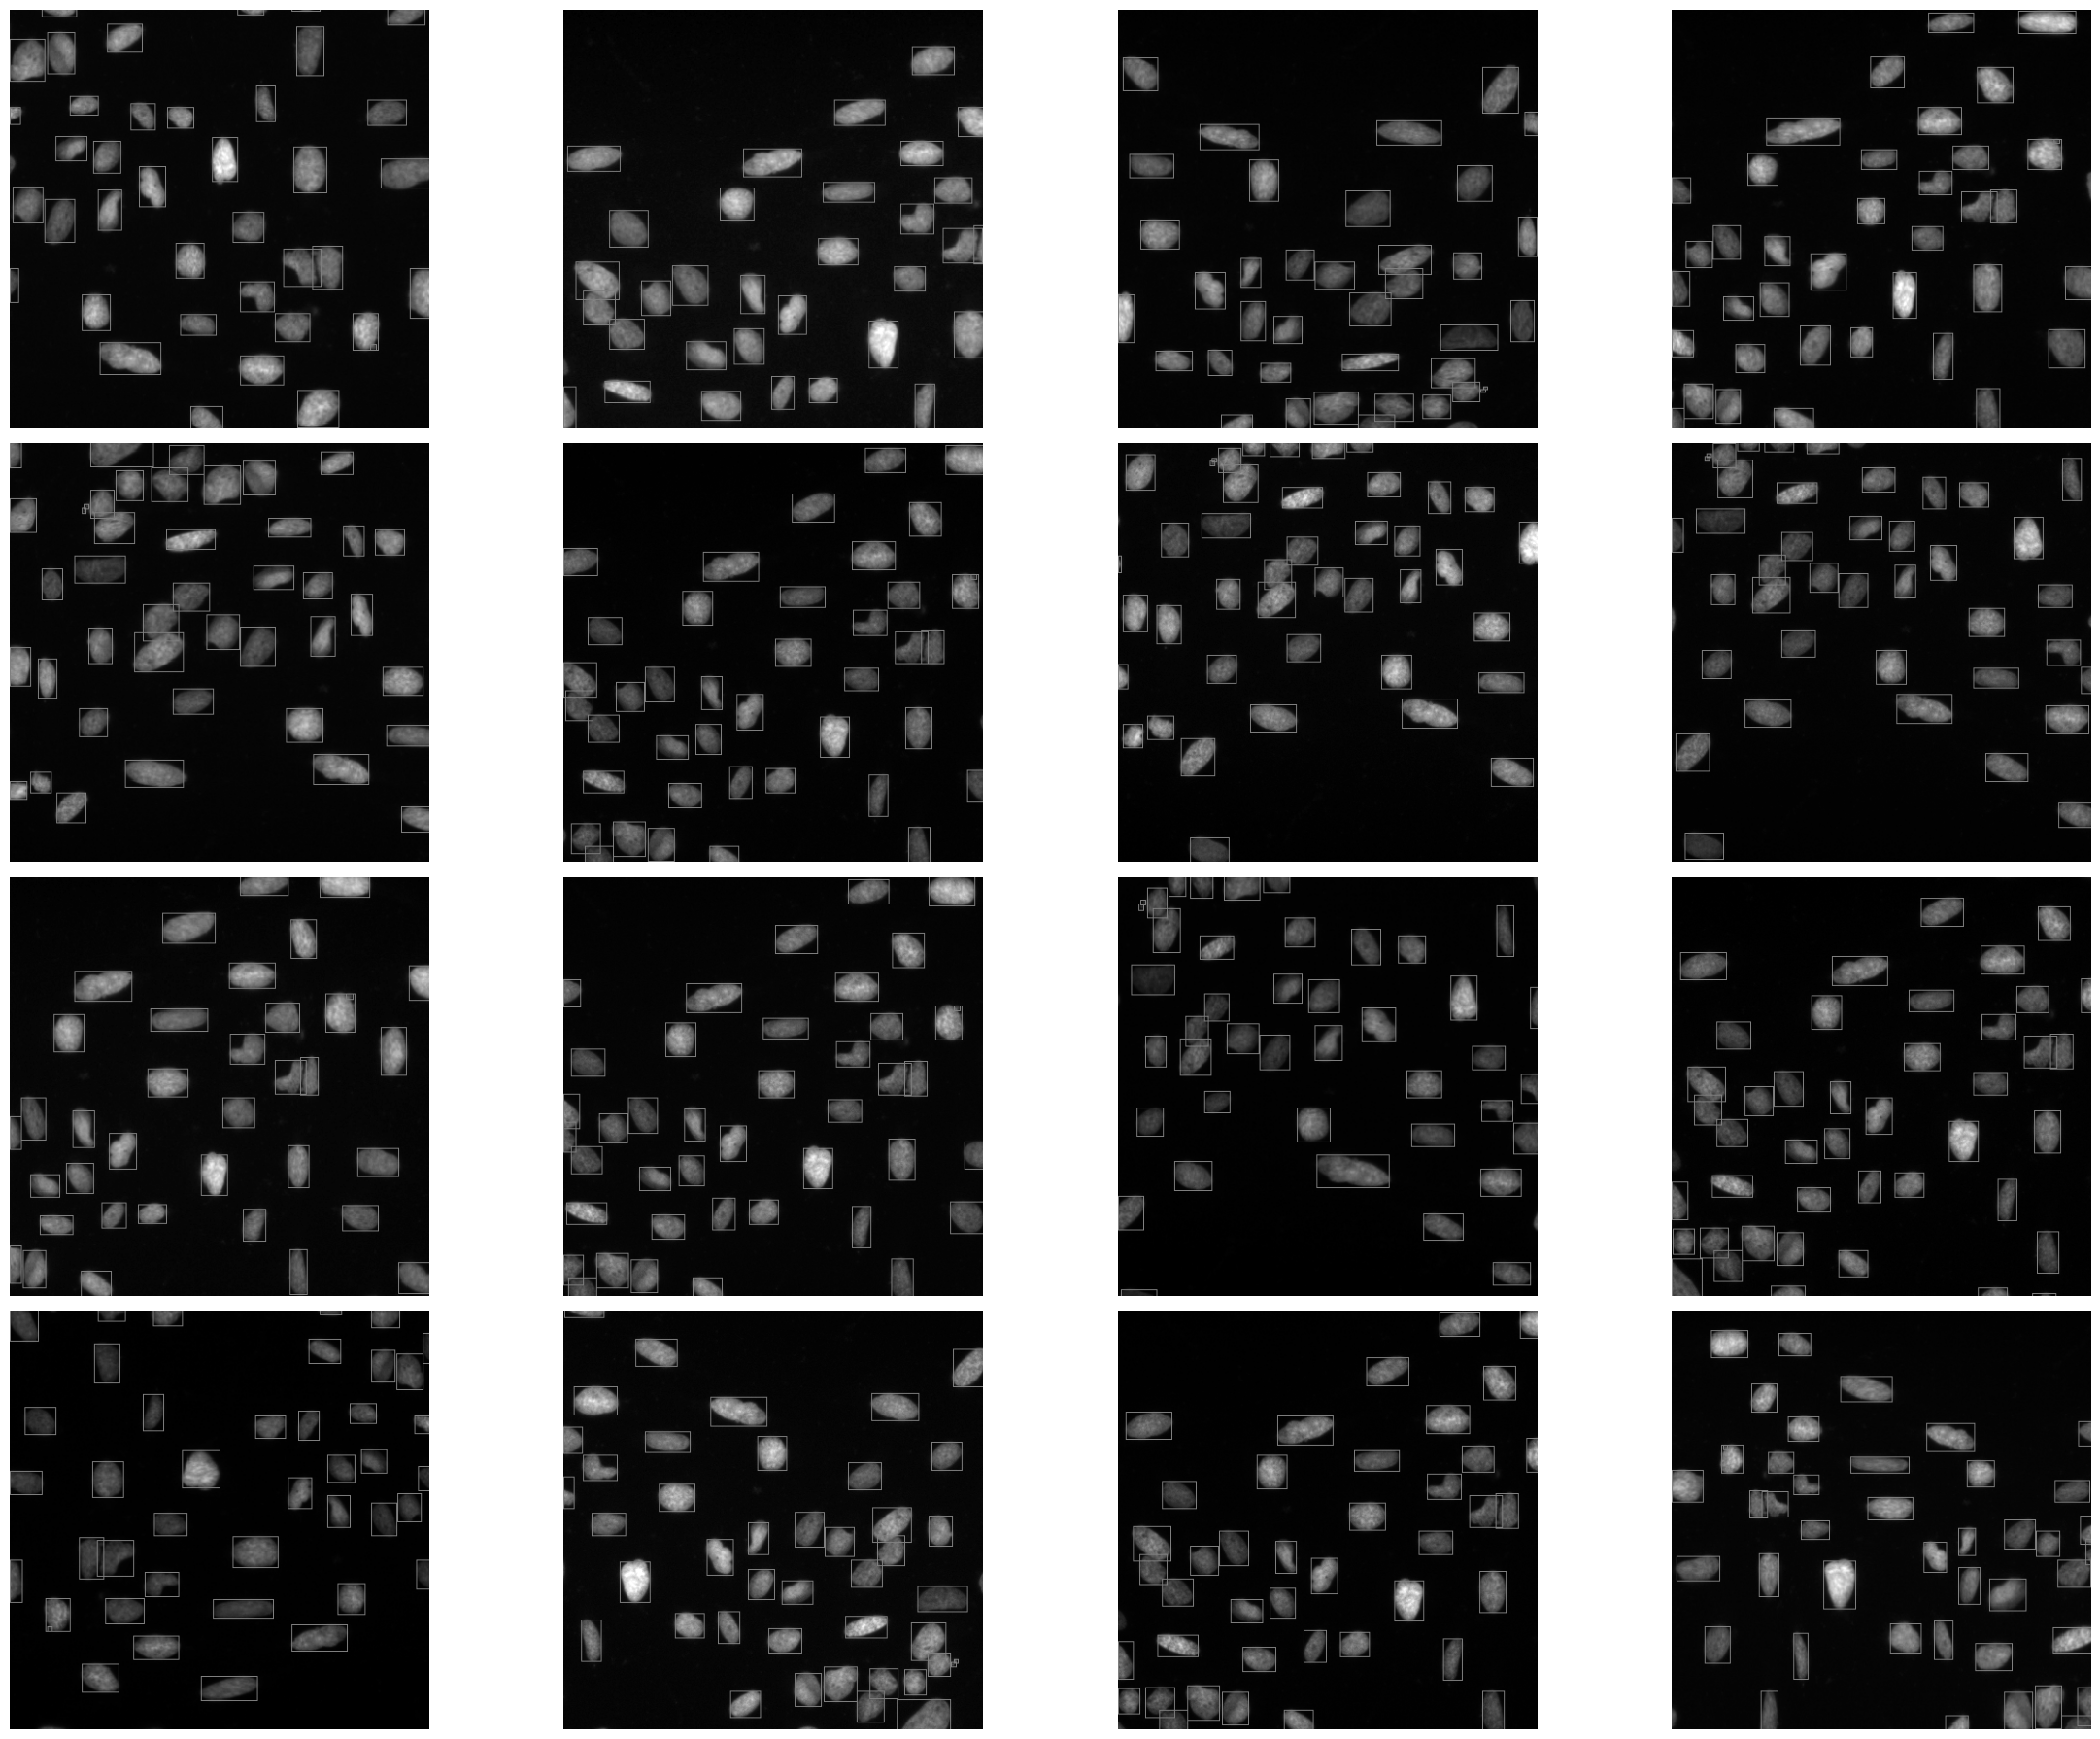

In [ ]:
ind = np.random.choice(len(train_ds))
img = train_ds.imgs[ind]
bboxes = train_ds.bboxes[ind]
aug = train_ds.get_transform()
_, axs = plt.subplots(4, 4, figsize=(24, 18))
axs = axs.flatten()
for ax in axs:
  transform = aug(image = img, bboxes = bboxes, indices=np.array(list(range(len(bboxes)))))
  tr_img = visualize_bbox(transform['image'].squeeze(), transform['bboxes'])
  ax.imshow(tr_img, cmap='gray', vmin=-1, vmax = 1)
  ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def decode_mask(masks, binary = True):
  if binary:
    mask = masks[0]
    decoded = np.zeros_like(mask)
    decoded[mask==1]=1
    decoded = skimage.morphology.label(decoded)
  else:
    if type(masks) == list:
      masks = torch.stack(masks)
    masks = np.arange(1, len(masks)+1)[:, None, None]*masks.numpy()
    decoded = np.max(masks, axis = 0)
  return decoded

In [ ]:
def plot_examples(loader, binary = True):
  batch = next(iter(loader))
  _, axs = plt.subplots(3, 4, figsize=(15, 10))
  axs = axs.flatten()
  data = batch[0][:6]+batch[1][:6]
  for i, ax in enumerate(axs):
    if i%2==0:
      img = data[i//2].squeeze()
      target  = data[6+i//2]
      if not binary:
        img = visualize_bbox(img, target['boxes'])
      ax.imshow(img, cmap='gray', vmin=-1, vmax = 1)
    else:
      target  = data[6+i//2]
      vmax = 2 if binary else len(target['masks'])
      mask = target['masks'][0] if binary else decode_mask(target['masks'], binary)
      cmap = 'gray' if binary else 'nipy_spectral'
      ax.imshow(mask, cmap=cmap, vmin=0, vmax = vmax)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

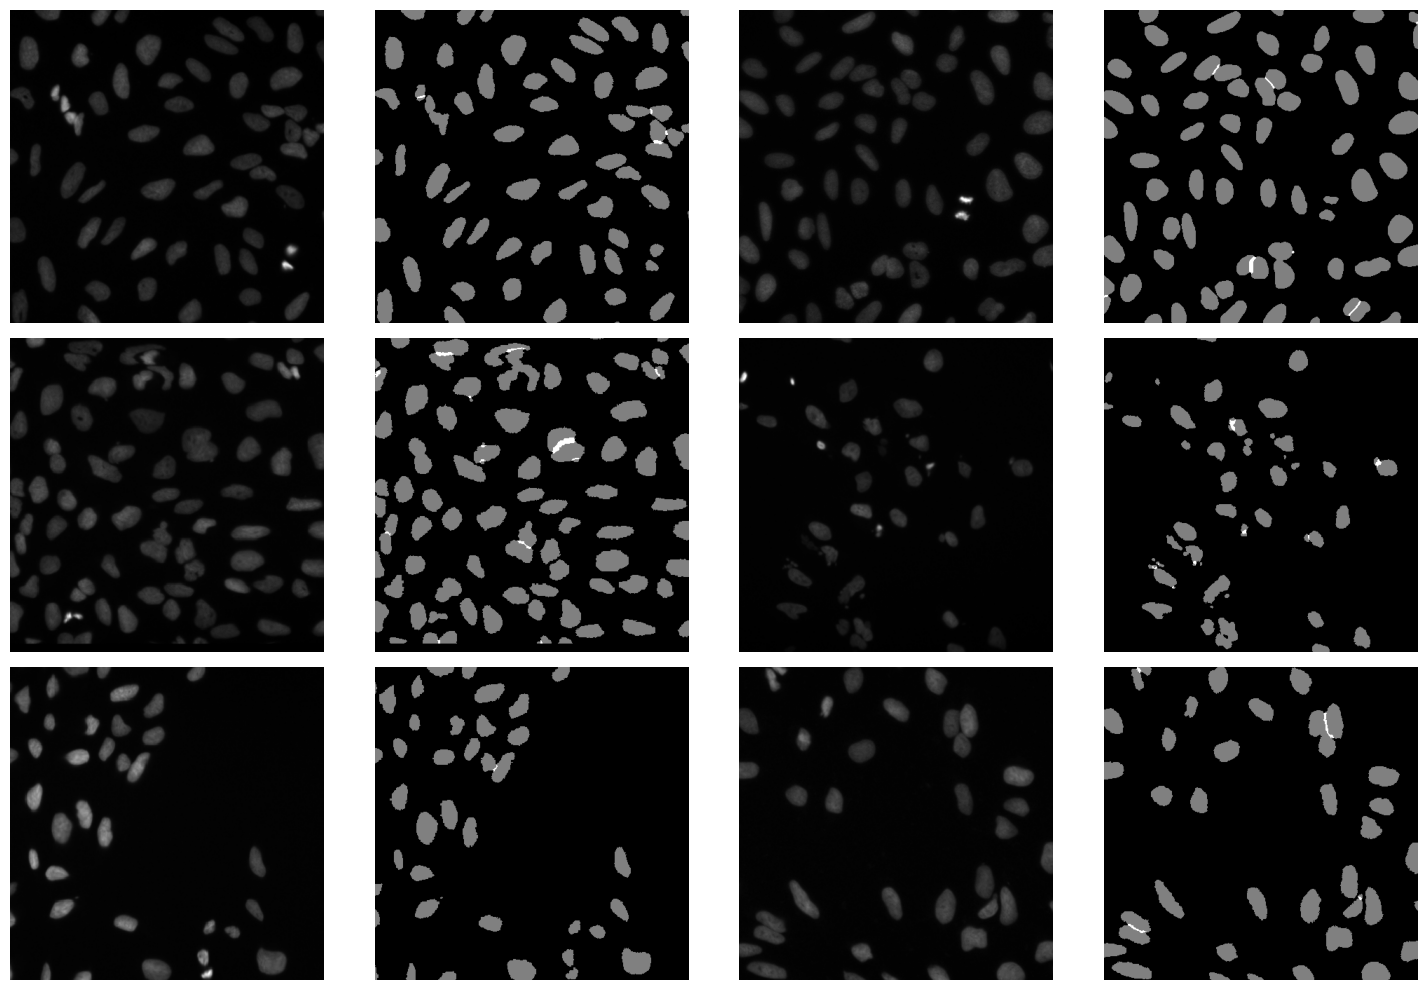

In [ ]:
plot_examples(train_loader)

## UNet

### Model

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_layers, num_classes):
        super().__init__()
        assert n_layers > 1
        #encoder
        self.dec = nn.ModuleList([UNetBlock(1, 2**5, mode = 'id')])
        for i in range(0, n_layers-1):
          self.dec.append(UNetBlock(2**(5+i), 2**(5+i+1), mode = 'down'))
        # decoder (upsampling)
        self.enc = nn.ModuleList()
        for i in reversed(range(0, n_layers - 1)):
          self.enc.append(UNetBlock(2**(5+i+1), 2**(5+i), mode = 'up_bil'))
        self.enc.append(nn.Conv2d(2**5, num_classes, 1))
        # self.final = nn.Conv2d(32, 1, kernel_size=1)
    def forward(self, img):
        # out = self.final(d1)
        dec_out = [None]
        for layer in self.dec:
          img = layer(img)
          dec_out.append(img)
        dec_out.pop()
        for layer in self.enc:
          y = dec_out.pop()
          if y is None:
            img = layer(img)
          else:
            img = layer(img, y)
        out = img
        return out

class UNetBlock(nn.Module):
  def __init__(self, in_ch, out_ch, mode = 'down'):
    super().__init__()
    self.mode = mode
    self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding = 1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding = 1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    if mode == 'down':
      self.resample = nn.Conv2d(out_ch, out_ch, kernel_size = 2, stride=2)
    elif mode == 'up_transp':
      self.resample = nn.ConvTranspose2d(in_ch, out_ch, kernel_size = 2, stride= 2)
    elif mode == 'up_bil':
      self.resample = nn.Sequential(nn.Conv2d(in_ch, out_ch, 3, padding = 1),
                                    nn.Upsample(scale_factor = 2, mode='bilinear'))
    else:
      self.resample = nn.Identity()

  def forward(self, x, y = None):
    if self.mode == 'down':
      x = self.conv(x)
      x = self.resample(x)
    else:
      x = self.resample(x)
      if not y is None:
        x = torch.cat([x, y], dim = 1)
      x = self.conv(x)
    return x


In [ ]:
!pip install -q torchinfo
from torchinfo import summary

In [ ]:
NUM_CLASSES = 3
NUM_LAYERS = 4

In [ ]:
c, h, w = next(iter(train_loader))[0][0].shape
summary(UNet(NUM_LAYERS, NUM_CLASSES), (BATCH_SIZE, c, h, w), device = 'cuda')

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [8, 3, 448, 448]          --
├─ModuleList: 1-1                        --                        --
│    └─UNetBlock: 2-1                    [8, 32, 448, 448]         --
│    │    └─Identity: 3-1                [8, 1, 448, 448]          --
│    │    └─Sequential: 3-2              [8, 32, 448, 448]         9,696
│    └─UNetBlock: 2-2                    [8, 64, 224, 224]         --
│    │    └─Sequential: 3-3              [8, 64, 448, 448]         55,680
│    │    └─Conv2d: 3-4                  [8, 64, 224, 224]         16,448
│    └─UNetBlock: 2-3                    [8, 128, 112, 112]        --
│    │    └─Sequential: 3-5              [8, 128, 224, 224]        221,952
│    │    └─Conv2d: 3-6                  [8, 128, 112, 112]        65,664
│    └─UNetBlock: 2-4                    [8, 256, 56, 56]          --
│    │    └─Sequential: 3-7              [8, 256, 112, 112]      

### Loss

In [ ]:
import torch.nn.functional as F
class FocalTverskyLoss(nn.Module):
    def __init__(self, num_classes = 3, alpha=0.7, beta=0.3, gamma = 0.75, weight = None):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.num_classes = num_classes
        self.weights = torch.tensor(weight)

    def forward(self, pred, label, eps = 1e-8):

        pred = torch.softmax(pred, dim = 1)
        target_onehot = F.one_hot(label, self.num_classes).permute(0, 3, 1, 2).to(pred.dtype)


        TP = torch.sum(target_onehot * pred, dim=(0, 2, 3))
        FN = torch.sum(target_onehot * (1-pred), dim=(0, 2, 3))
        FP = torch.sum((1-target_onehot)*pred, dim=(0, 2, 3))

        loss = (TP + eps) / (TP + self.alpha * FP + self.beta * FN + eps)
        loss = torch.pow(loss, self.gamma)
        if not self.weights is None:
          loss *= self.weights.to(loss.device)
        return 1 - loss.mean()

### Training pipeline

In [ ]:
from torchvision.utils import make_grid
class UNetTrainer(nn.Module):
  def __init__(self, model, optimizer, scheduler, criterion, metric, train_loader, val_loader, fp16 = False, ckpt_name ="checkpoint.pth"):
    super().__init__()
    self.model = model
    self.optimizer = optimizer
    self.scheduler = scheduler
    self.criterion = criterion
    self.metric = metric
    self.train_loader = train_loader
    self.val_loader = val_loader
    self.ckpt_name = Path(ckpt_name)
    self.epoch = 0
    self.scaler = torch.cuda.amp.GradScaler() if fp16 else None
    self.loss_curves = dict(train = [], val = [])
    self.metric_curves = dict(train = [], val = [])

  @property
  def device(self):
    return next(self.model.parameters()).device

  def graph_setup(self):
    fig1, axes1 = plt.subplots(1, 3, figsize=(15, 4))
    fig2, axes2 = plt.subplots(1, 2, figsize=(15, 4))

    dh1 = display(fig1, display_id=True)
    dh2 = display(fig2, display_id=True)

    img_titles = ['Image', 'Prediction', 'Ground Truth']
    plot_titles = ['Loss', 'IoU']
    for ax, title in zip(axes1, img_titles):
      ax.axis('off')
      ax.set_title(title)
    for ax, title in zip(axes2, plot_titles):
      ax.set_title(title)

    self.graph_dict = dict(graph_1 = (dh1, fig1),
                      graph_2 = (dh2, fig2),
                      axes_1 = axes1,
                      axes_2 = axes2)

  def plot_triplet(self, img, pred, label):
    # self.graph_dict['axes_1'][0].cla()
    # self.graph_dict['axes_1'][1].cla()
    # self.graph_dict['axes_1'][2].cla()

    self.graph_dict['axes_1'][0].imshow(img, cmap='gray', vmin=-1, vmax = 1)
    self.graph_dict['axes_1'][1].imshow(pred, vmin=0, vmax = 2)
    self.graph_dict['axes_1'][2].imshow(label, vmin=0, vmax = 2)
    dh, fig = self.graph_dict['graph_1']
    dh.update(fig)

  def update_curves(self):
    labels = ['train', 'val']
    ticks_1 = np.arange(1, 1+len(self.loss_curves[labels[0]]))/(len(self.train_loader))
    ticks_2 = np.arange(1, 1+len(self.loss_curves[labels[1]]))/(len(self.val_loader))
    ticks_1[0] = 0
    if len(ticks_2)>0:
      ticks_2[0] = 0

    # self.graph_dict['axes_2'][0].cla()
    # self.graph_dict['axes_2'][1].cla()

    line1, = self.graph_dict['axes_2'][0].plot(ticks_1, self.loss_curves[labels[0]], c = 'r', label = labels[0])
    line2, = self.graph_dict['axes_2'][0].plot(ticks_2, self.loss_curves[labels[1]], c = 'b', label = labels[1])
    self.graph_dict['axes_2'][0].legend(handles=[line1, line2])

    line3, = self.graph_dict['axes_2'][1].plot(ticks_1, self.metric_curves[labels[0]], c = 'r', label = labels[0])
    line4, = self.graph_dict['axes_2'][1].plot(ticks_2, self.metric_curves[labels[1]], c = 'b', label = labels[1])
    self.graph_dict['axes_2'][1].legend(handles=[line3, line4])

    dh, fig = self.graph_dict['graph_2']
    dh.update(fig)

  def train_one_epoch(self):
    self.model.train()
    device = self.device
    batch_num = 0
    for pics, targets in tqdm(self.train_loader, leave = False):
        pics = torch.stack([pic for pic in pics]).to(device)
        masks = torch.stack([target['masks'][0] for target in targets]).to(device)
        self.optimizer.zero_grad()
        with torch.cuda.amp.autocast(self.scaler is not None):
          outputs = self.model(pics)
          loss = self.criterion(outputs, masks.long())
        if self.scaler is None:
          loss.backward()
          self.optimizer.step()
        else:
          self.scaler.scale(loss).backward()
          self.scaler.step(self.optimizer)
          self.scaler.update()

        self.metric_curves['train'].append(self.metric(outputs, masks).detach().item()*100)
        self.loss_curves['train'].append(loss.detach().item())

        if batch_num % 4 == 0:
          self.update_curves()

        batch_num+=1

  @torch.no_grad()
  def validate(self):
    self.model.eval()
    device = self.device
    batch_num = 0
    for pics, targets in tqdm(self.val_loader, leave = False):
        pics = torch.stack([pic for pic in pics]).to(device)
        masks = torch.stack([target['masks'][0] for target in targets]).to(device)
        with torch.cuda.amp.autocast(self.scaler is not None):
          outputs = self.model(pics)
          val_loss = self.criterion(outputs, masks.long())
        self.metric_curves['val'].append(self.metric(outputs, masks).item()*100)
        self.loss_curves['val'].append(val_loss.item())

        self.update_curves()
        if batch_num == 0:
          pred = outputs.argmax(dim = 1)
          self.plot_triplet(pics[0, 0].cpu(), pred[0].cpu(), masks[0].cpu())
        batch_num+=1

  def train(self, num_epochs, resume=False):
    self.epoch = 0
    self.num_epochs = num_epochs
    pbar = tqdm(total = num_epochs)
    min_val_acc = np.inf
    self.graph_setup()
    if resume and self.ckpt_name.exists():
        self.load()
        pbar.update(self.epoch)
        min_val_acc = min(self.metric_curves['val'])

    while self.epoch < num_epochs:
        self.train_one_epoch()
        self.epoch += 1
        pbar.update(1)
        self.validate()
        if self.metric_curves['val'][-1]<min_val_acc:
          self.save()
        self.scheduler.step()
    plt.close()
    plt.close()

  @torch.no_grad()
  def calc_metric(self, test_loader, plot = True, n_average = 10):
    self.model.eval()
    device = self.device
    metrics = []
    for i in tqdm(range(n_average)):
      for pics, targets in test_loader:
          pics = torch.stack([pic for pic in pics]).to(device)
          masks = torch.stack([target['masks'][0] for target in targets]).to(device)
          outputs = self.model(pics)
          metrics.append(self.metric(outputs, masks).item()*100)
    if plot:
      decoded_masks =[]
      for out in outputs:
        decoded_masks.append(torch.tensor(decode_mask([out.argmax(0).detach().cpu()])))
      decoded = torch.stack(decoded_masks).long().unsqueeze(1)
      img_grid = make_grid((pics+1)/2, nrow=8)
      plt.figure(figsize = (20,10))
      plt.imshow(img_grid.permute(1, 2, 0).cpu(), cmap='gray', vmin = 0, vmax = 1)
      plt.axis('off')
      plt.show()
      img_grid = torch.max(make_grid(decoded, nrow=8), dim = 0).values
      plt.figure(figsize = (20,10))
      vmax=img_grid.max().item()
      plt.imshow(img_grid.numpy().astype('uint8'), cmap='nipy_spectral', vmin = 0, vmax = vmax)
      plt.axis('off')
      plt.show()
    return np.mean(metrics)

  @torch.no_grad()
  def predict(self, images):
    self.model.eval()
    device = self.device
    images = images.to(device)
    outputs = self.model(images)
    return outputs

  def save(self):
    torch.save(dict(
        model=self.model.state_dict(),
        optimizer=self.optimizer.state_dict(),
        scheduler = self.scheduler.state_dict(),
        epoch=self.epoch,
        loss_curves = self.loss_curves,
        metric_curves = self.metric_curves
    ), self.ckpt_name)

  def load(self):
    print('Loading checkpoint', self.ckpt_name)
    ckpt = torch.load(self.ckpt_name)
    self.model.load_state_dict(ckpt['model'])
    self.optimizer.load_state_dict(ckpt['optimizer'])
    self.scheduler.load_state_dict(ckpt['scheduler'])
    self.epoch = ckpt['epoch']
    self.loss_curves = ckpt['loss_curves'],
    self.metric_curves = ckpt['metric_curves']

### Training and inference

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
y = np.array(train_ds.labels).flatten()
# weights = compute_class_weight('balanced', classes = range(NUM_CLASSES), y = np.array(train_ds.labels).flatten())
# weights = compute_class_weight(None, classes = np.arange(NUM_CLASSES), y = np.array(train_ds.labels).flatten())
weights = [1., 2., 2.]
print(weights)

[1.0, 2.0, 3]


In [ ]:
NUM_EPOCHS = 35
criterion = FocalTverskyLoss(NUM_CLASSES, weight = weights)
# criterion = nn.CrossEntropyLoss(weight = torch.tensor(weights).float())
metric = MulticlassJaccardIndex(NUM_CLASSES)
model = UNet(NUM_LAYERS, NUM_CLASSES)
# optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, weight_decay=0.0005, lr = 1e-3)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.5)

In [ ]:
trainer = UNetTrainer(model, optimizer, scheduler, criterion, metric, train_loader, val_loader)

  0%|          | 0/35 [00:00<?, ?it/s]

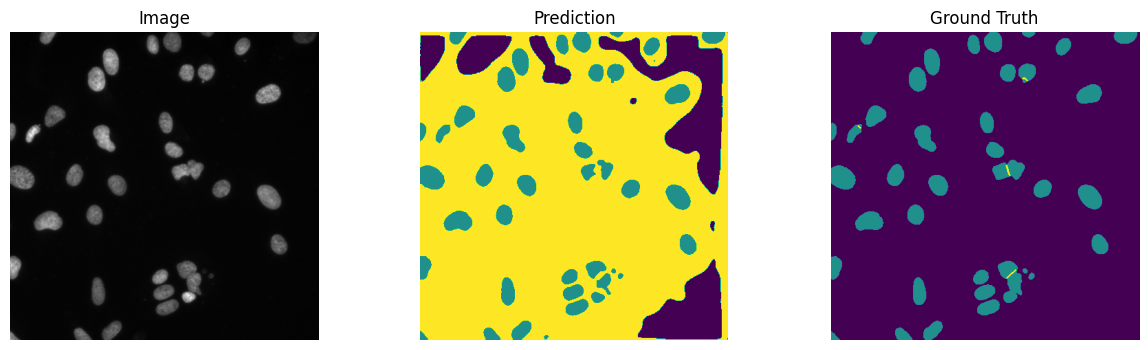

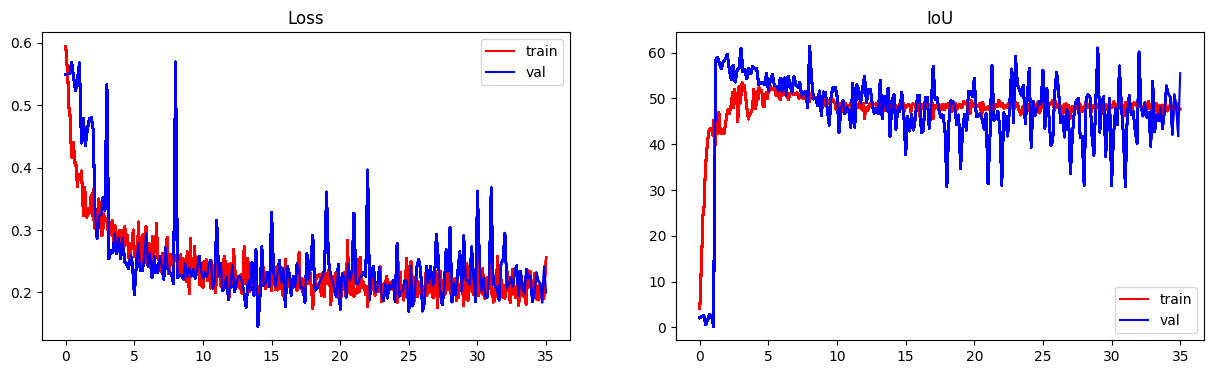

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
trainer = trainer.cuda()
trainer.train(NUM_EPOCHS)

  0%|          | 0/1 [00:00<?, ?it/s]

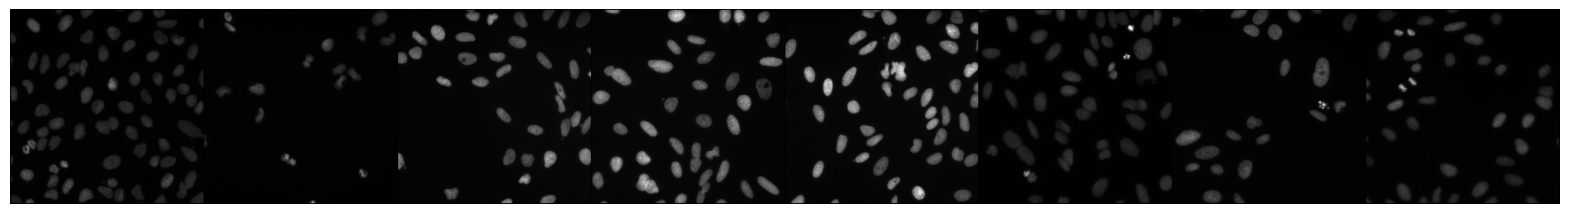

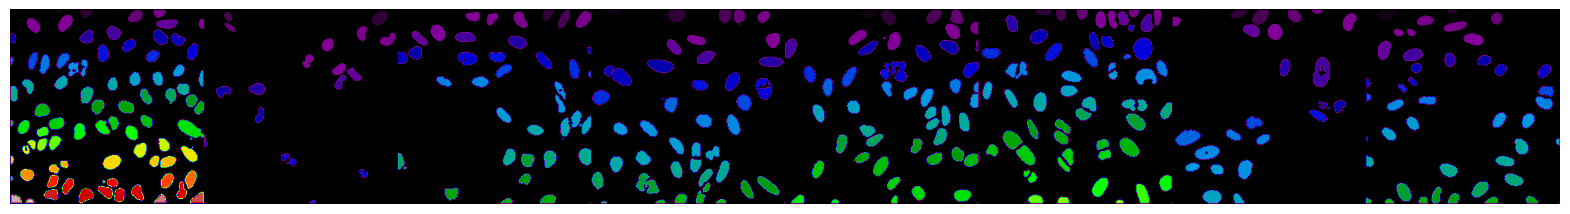

45.303019881248474

In [ ]:
trainer.calc_metric(test_loader, n_average=1)

## Unet Grid Search

In [ ]:
import pandas as pd

class GridSearcher:
  def __init__(self, param_dict):
    self.param_dict = param_dict

  def beautify_table(self):
    col_names = ['model', 'model_params', 'lr', 'weights', 'loss_func', 'fp16', 'test IoU']
    df = pd.DataFrame(self.result, columns = col_names)
    df['weights'] = df['weights'].apply(np.array)
    return df

  def search(self):
    self.result = []
    num_epochs = self.param_dict['num_epochs']
    metric = self.param_dict['metric']
    fp_16_flags = self.param_dict['fp_16_flags']
    criterions = self.param_dict['criterions']
    weights_list = self.param_dict['weights_list']
    lrs = self.param_dict['lrs']
    model_archs = self.param_dict['model_archs']
    model_params = self.param_dict['model_params']
    train_loader, val_loader, test_loader = self.param_dict['loaders']
    last_test_acc = 0
    for fp_16 in fp_16_flags:
      for model_arch in model_archs:
        for model_param in model_params:
          for lr in lrs:
            for weights in weights_list:
              for criterion in criterions:
                params = [str(model_arch), model_param, lr, weights, str(criterion), fp_16]
                print('Current run:')
                print(params)
                model = model_arch(**model_param)
                optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
                scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 8, 0.5)
                loss_fn = criterion(weight = weights)
                trainer = UNetTrainer(model, optimizer, scheduler, loss_fn, metric, train_loader, val_loader, fp_16)
                trainer = trainer.cuda()
                trainer.train(num_epochs)
                test_acc = trainer.calc_metric(test_loader, plot = False)
                if test_acc > last_test_acc:
                  trainer.save()
                  last_test_acc = test_acc
                self.result.append(params+ [test_acc])
                clear_output()
                print('Previous run:')
                print(self.result[-1])
    clear_output()
    return self.beautify_table()

In [ ]:
weights_list = torch.tensor([[1, 1, 1], [1, 2, 2], [1, 2, 3], [1, 2, 4], [1, 2, 2.5], [1, 3, 1.5]], requires_grad=False)

search_dict = {'num_epochs' : 30,
               'metric': MulticlassJaccardIndex(NUM_CLASSES),
               'criterions': [nn.CrossEntropyLoss, FocalTverskyLoss],
               'weights_list': weights_list,
               'lrs': [1e-4],
               'fp_16_flags': [False],
               'model_archs': [UNet],
               'model_params': [{'n_layers': NUM_LAYERS,
                                 'num_classes': NUM_CLASSES}],
               'loaders': (train_loader, val_loader, test_loader)}



In [ ]:
gs = GridSearcher(search_dict)
search_result = gs.search()
search_result

## RCNN's

### Data

In [ ]:
BATCH_SIZE = 4
DOWNLOAD = True
train_ds = BBBC039_Dataset(mode = 'seg', download=DOWNLOAD)
val_ds = BBBC039_Dataset(split = 'val', mode = 'seg', download=False)
test_ds = BBBC039_Dataset(split = 'test', mode = 'seg', download=False)

train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle = True, collate_fn=lambda x:list(zip(*x)))
val_loader = DataLoader(val_ds, BATCH_SIZE, shuffle = True, collate_fn=lambda x:list(zip(*x)))
test_loader = DataLoader(test_ds, BATCH_SIZE, drop_last = True, collate_fn=lambda x:list(zip(*x)))

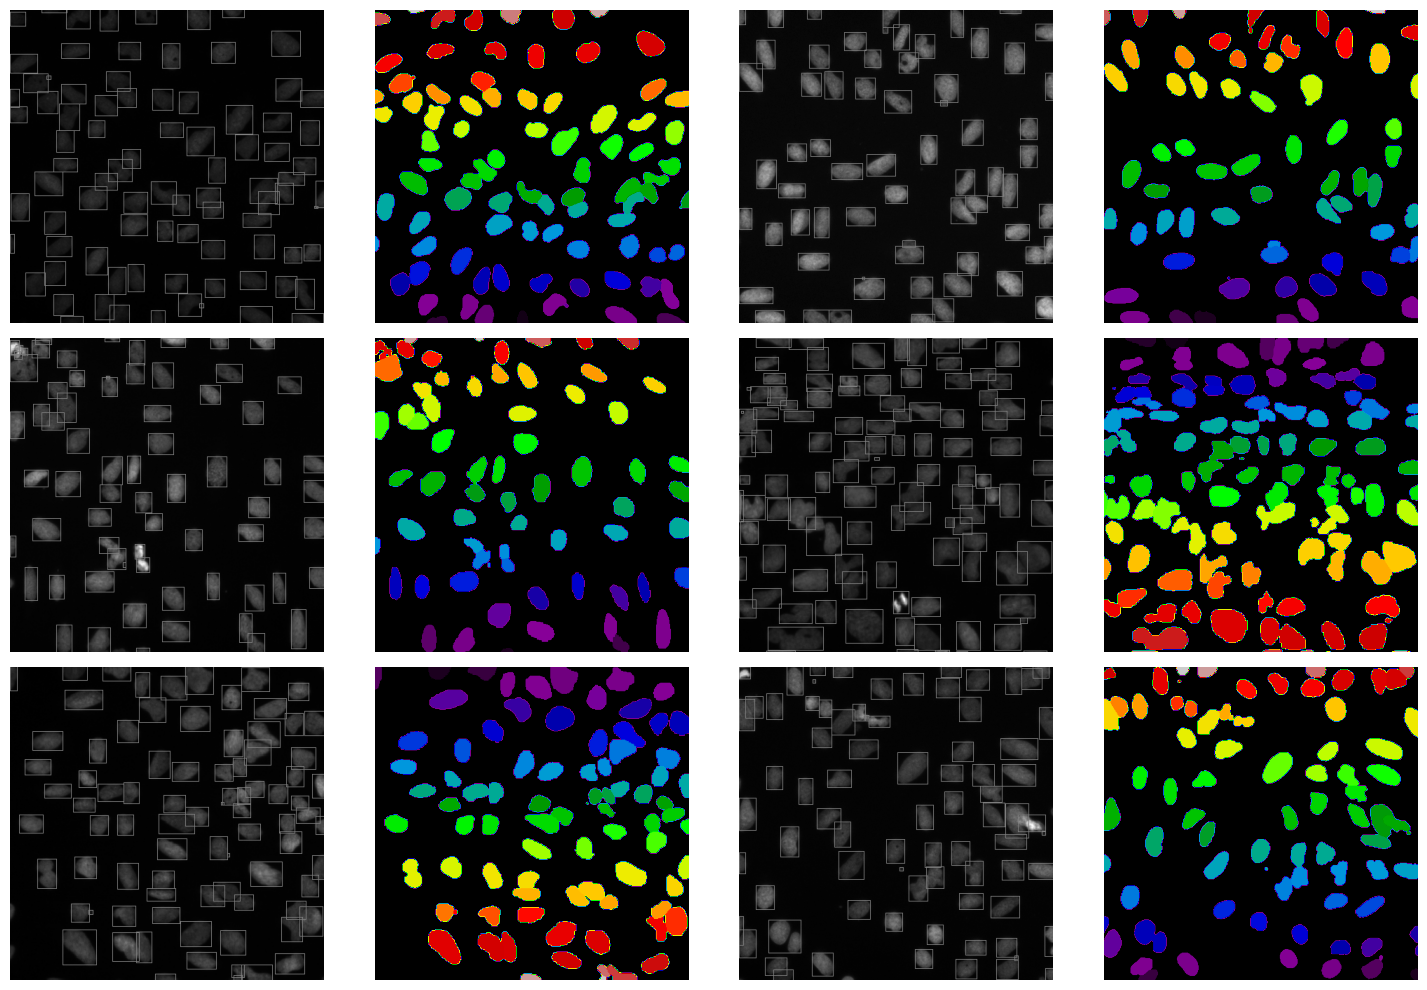

In [ ]:
temp_loader = DataLoader(train_ds, 8, shuffle = True, collate_fn=lambda x:list(zip(*x)))
plot_examples(temp_loader, binary = False)

### Training pipeline

In [ ]:
class RCNNTrainer(nn.Module):
  def __init__(self, lr, criterion, metric, train_loader, val_loader, mode = 'det', fp16 = False, ckpt_name ="checkpoint_rcnn.pth"):
    super().__init__()
    mean = torch.Tensor([0,0,0])
    std = torch.Tensor([1,1,1])
    if mode == 'det':
      self.model = FasterRCNN(num_classes=2, min_size = 448, image_mean=mean, image_std=std)
    else:
      self.model = MaskRCNN(num_classes=2, min_size = 448, image_mean=mean, image_std=std)
    self.mode = mode
    self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
    self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 5, 0.5)
    self.criterion = criterion
    self.metric = metric
    self.train_loader = train_loader
    self.val_loader = val_loader
    self.ckpt_name = Path(ckpt_name)
    self.epoch = 0
    self.scaler = torch.cuda.amp.GradScaler() if fp16 else None
    self.loss_curves = dict(train = [], val = [])
    self.metric_curves = dict(train = [], val = [])

  @property
  def device(self):
    return next(self.model.parameters()).device

  def graph_setup(self):
    fig1, axes1 = plt.subplots(1, 3, figsize=(15, 4))
    fig2, axes2 = plt.subplots(1, 2, figsize=(15, 4))

    dh1 = display(fig1, display_id=True)
    dh2 = display(fig2, display_id=True)

    img_titles = ['Image', 'Prediction', 'Ground Truth']
    plot_titles = ['Train loss', 'Validation mAP']
    for ax, title in zip(axes1, img_titles):
      ax.axis('off')
      ax.set_title(title)
    for ax, title in zip(axes2, plot_titles):
      ax.set_title(title)

    self.graph_dict = dict(graph_1 = (dh1, fig1),
                      graph_2 = (dh2, fig2),
                      axes_1 = axes1,
                      axes_2 = axes2)

  def plot_triplet(self, img, pred, label):

    pred_bboxes = [bbox.cpu() for bbox, score in zip(pred['boxes'], pred['scores']) if score > 0.5]
    true_bboxes = [bbox.cpu() for bbox in label['boxes']]

    self.graph_dict['axes_1'][0].imshow(img, cmap='gray', vmin=-1, vmax = 1)
    if self.mode == 'det':
      pred_boxes_img = visualize_bbox(img, pred_bboxes)
      true_boxes_img = visualize_bbox(img, true_bboxes)

      self.graph_dict['axes_1'][1].imshow(pred_boxes_img, cmap='gray', vmin=-1, vmax = 1)
      self.graph_dict['axes_1'][2].imshow(true_boxes_img, cmap='gray', vmin=-1, vmax = 1)
    else:
      pred_mask_img = decode_mask((pred['masks'].squeeze().detach().cpu()>0.5).long(), binary = False)
      # pred_mask_img = visualize_bbox(pred_mask_img, pred_bboxes)

      true_mask_img = decode_mask(label['masks'].squeeze().detach().cpu(), binary = False)
      # true_mask_img = visualize_bbox(true_mask_img, true_bboxes)

      vmax = true_mask_img.max()

      self.graph_dict['axes_1'][1].imshow(pred_mask_img, cmap='nipy_spectral', vmin=0, vmax = vmax)
      self.graph_dict['axes_1'][2].imshow(true_mask_img, cmap='nipy_spectral', vmin=0, vmax = vmax)
    dh, fig = self.graph_dict['graph_1']
    dh.update(fig)

  def update_curves(self):
    labels = ['train', 'val']
    ticks_1 = np.arange(1, 1+len(self.loss_curves[labels[0]]))/(len(self.train_loader))
    ticks_2 = np.arange(0, len(self.metric_curves[labels[1]]))
    ticks_1[0] = 0

    self.graph_dict['axes_2'][0].plot(ticks_1, self.loss_curves[labels[0]], c = 'r')
    self.graph_dict['axes_2'][1].plot(ticks_2, self.metric_curves[labels[1]], c = 'b')

    dh, fig = self.graph_dict['graph_2']
    dh.update(fig)

  def train_one_epoch(self):
    self.model.train()
    device = self.device
    batch_num = 0
    for images, targets in tqdm(self.train_loader, leave = False):

        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) if k != 'masks' else torch.stack(v).to(device) for k, v in t.items()} for t in targets]

        self.optimizer.zero_grad()
        with torch.cuda.amp.autocast(self.scaler is not None):
          outputs = self.model(images, targets)
          loss = self.criterion['w_conf']*outputs['loss_objectness']+ \
                  self.criterion['w_reg']*outputs['loss_box_reg']+ \
                  self.criterion['w_reg_rpn']*outputs['loss_rpn_box_reg'] + \
                  self.criterion['w_cls']*outputs['loss_classifier']
          if self.mode != 'det':
            loss += self.criterion['w_mask']*outputs['loss_mask']
        if self.scaler is None:
          loss.backward()
          self.optimizer.step()
        else:
          self.scaler.scale(loss).backward()
          self.scaler.step(self.optimizer)
          self.scaler.update()

        self.loss_curves['train'].append(loss.detach().item())

        if batch_num % 4 == 0:
          self.update_curves()

        batch_num+=1

  @torch.no_grad()
  def validate(self):
    self.model.eval()
    device = self.device

    images, targets = next(iter(self.val_loader))

    images = list(image.to(device) for image in images)
    targets = [{k: torch.tensor(v).to(device) if k != 'masks' else torch.stack(v).to(device) for k, v in t.items()} for t in targets]

    with torch.cuda.amp.autocast(self.scaler is not None):
      outputs = self.model(images)

    self.update_curves()
    self.metric.update(outputs, targets)
    metric_eval = self.metric.compute()['map']
    self.metric_curves['val'].append(metric_eval.item()*100)
    self.plot_triplet(images[0][0].cpu(), outputs[0], targets[0])


  def train(self, num_epochs, resume=False):
    self.epoch = 0
    self.num_epochs = num_epochs
    pbar = tqdm(total = num_epochs)
    min_val_acc = np.inf
    self.graph_setup()
    if resume and self.ckpt_name.exists():
        self.load()
        pbar.update(self.epoch)
        min_val_acc = min(self.metric_curves['val'])

    while self.epoch < num_epochs:
        self.train_one_epoch()
        self.epoch += 1
        pbar.update(1)
        self.validate()
        if self.metric_curves['val'][-1]<min_val_acc:
          self.save()
        self.scheduler.step()
    plt.close()
    plt.close()

  @torch.no_grad()
  def calc_metric(self, test_loader):
    self.model.eval()
    device = self.device
    metrics = []
    for images, targets in tqdm(test_loader):
      images = list(image.to(device) for image in images)
      targets = [{k: torch.tensor(v).to(device) if k != 'masks' else torch.stack(v).to(device) for k, v in t.items()} for t in targets]
      outputs = self.model(images)
      self.metric.update(outputs, targets)
      metric_eval = self.metric.compute()['map']
      metrics.append(metric_eval.item()*100)
    return np.mean(metrics)

  @torch.no_grad()
  def predict(self, images):
    self.model.eval()
    device = self.device
    images = list(image.to(device) for image in images)
    outputs = self.model(images)
    return outputs

  def save(self):
    torch.save(dict(
        model=self.model.state_dict(),
        optimizer=self.optimizer.state_dict(),
        scheduler = self.scheduler.state_dict(),
        epoch=self.epoch,
        loss_curves = self.loss_curves,
        metric_curves = self.metric_curves
    ), self.ckpt_name)

  def load(self):
    print('Loading checkpoint', self.ckpt_name)
    ckpt = torch.load(self.ckpt_name)
    self.model.load_state_dict(ckpt['model'])
    self.optimizer.load_state_dict(ckpt['optimizer'])
    self.scheduler.load_state_dict(ckpt['scheduler'])
    self.epoch = ckpt['epoch']
    self.loss_curves = ckpt['loss_curves'],
    self.metric_curves = ckpt['metric_curves']

### Faster RCNN

In [ ]:
!pip install -q torchinfo
from torchinfo import summary

In [ ]:
pics, targets = next(iter(train_loader))
images = list(image.to('cuda') for image in pics)
targets = [{k: torch.tensor(v).to('cuda') if k != 'masks' else torch.stack(v).to('cuda') for k, v in t.items()} for t in targets]
summary(FasterRCNN(num_classes=2, min_size = 512), input_data=(images, targets), device = 'cuda')

Layer (type:depth-idx)                             Output Shape              Param #
FasterRCNN                                         [100, 4]                  --
├─GeneralizedRCNNTransform: 1-1                    [4, 3, 512, 512]          --
├─BackboneWithFPN: 1-2                             [4, 256, 8, 8]            --
│    └─IntermediateLayerGetter: 2-1                [4, 2048, 16, 16]         --
│    │    └─Conv2d: 3-1                            [4, 64, 256, 256]         9,408
│    │    └─BatchNorm2d: 3-2                       [4, 64, 256, 256]         128
│    │    └─ReLU: 3-3                              [4, 64, 256, 256]         --
│    │    └─MaxPool2d: 3-4                         [4, 64, 128, 128]         --
│    │    └─Sequential: 3-5                        [4, 256, 128, 128]        215,808
│    │    └─Sequential: 3-6                        [4, 512, 64, 64]          1,219,584
│    │    └─Sequential: 3-7                        [4, 1024, 32, 32]         7,098,368
│    │    └─

In [ ]:
NUM_EPOCHS = 35
criterion = dict(w_conf = 1, w_reg = 1, w_reg_rpn = 1, w_cls = 0.25)
mode = 'det'
lr = 5e-3
metric = MeanAveragePrecision()

In [ ]:
trainer = RCNNTrainer(lr, criterion, metric, train_loader, val_loader, mode)

  0%|          | 0/35 [00:00<?, ?it/s]

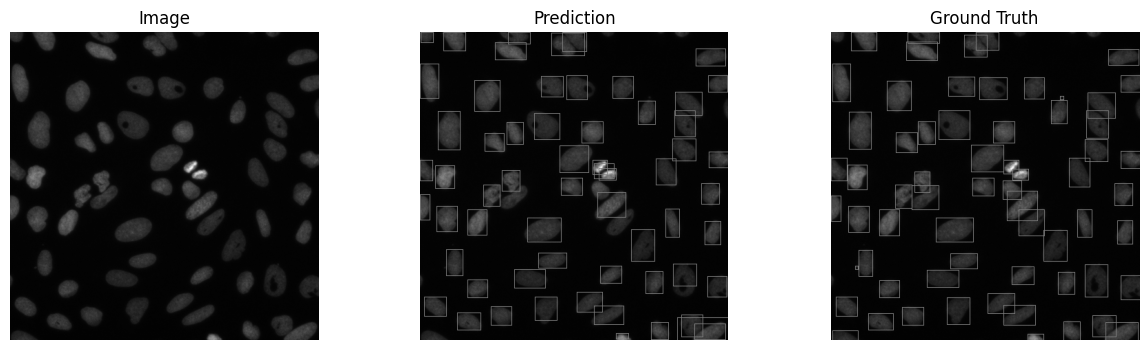

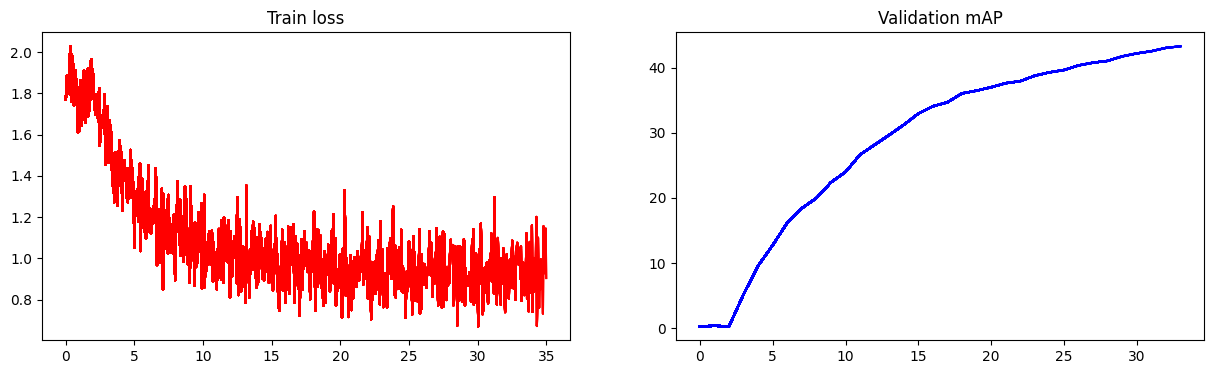

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
trainer = trainer.cuda()
trainer.train(NUM_EPOCHS)

In [ ]:
trainer.calc_metric(test_loader)

  0%|          | 0/12 [00:00<?, ?it/s]

45.20593509078026

### Mask RCNN

In [ ]:
pics, targets = next(iter(train_loader))
images = list(image.to('cuda') for image in pics)
targets = [{k: torch.tensor(v).to('cuda') if k != 'masks' else torch.stack(v).to('cuda') for k, v in t.items()} for t in targets]
summary(MaskRCNN(num_classes=2, min_size = 512), input_data=(images, targets), device = 'cuda')

Layer (type:depth-idx)                             Output Shape              Param #
MaskRCNN                                           [100, 4]                  --
├─GeneralizedRCNNTransform: 1-1                    [4, 3, 512, 512]          --
├─BackboneWithFPN: 1-2                             [4, 256, 8, 8]            --
│    └─IntermediateLayerGetter: 2-1                [4, 2048, 16, 16]         --
│    │    └─Conv2d: 3-1                            [4, 64, 256, 256]         9,408
│    │    └─BatchNorm2d: 3-2                       [4, 64, 256, 256]         128
│    │    └─ReLU: 3-3                              [4, 64, 256, 256]         --
│    │    └─MaxPool2d: 3-4                         [4, 64, 128, 128]         --
│    │    └─Sequential: 3-5                        [4, 256, 128, 128]        215,808
│    │    └─Sequential: 3-6                        [4, 512, 64, 64]          1,219,584
│    │    └─Sequential: 3-7                        [4, 1024, 32, 32]         7,098,368
│    │    └─

In [ ]:
NUM_EPOCHS = 30
criterion = dict(w_conf = 1, w_reg = 1, w_reg_rpn = 1, w_cls = 0.25, w_mask = 2)
mode = 'seg'
lr = 5e-3
metric = MeanAveragePrecision()

In [ ]:
trainer = RCNNTrainer(lr, criterion, metric, train_loader, val_loader, mode)

  0%|          | 0/30 [00:00<?, ?it/s]

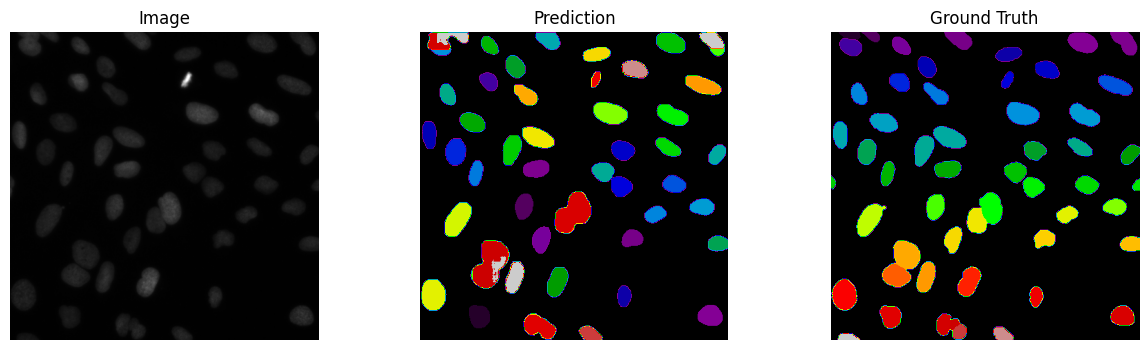

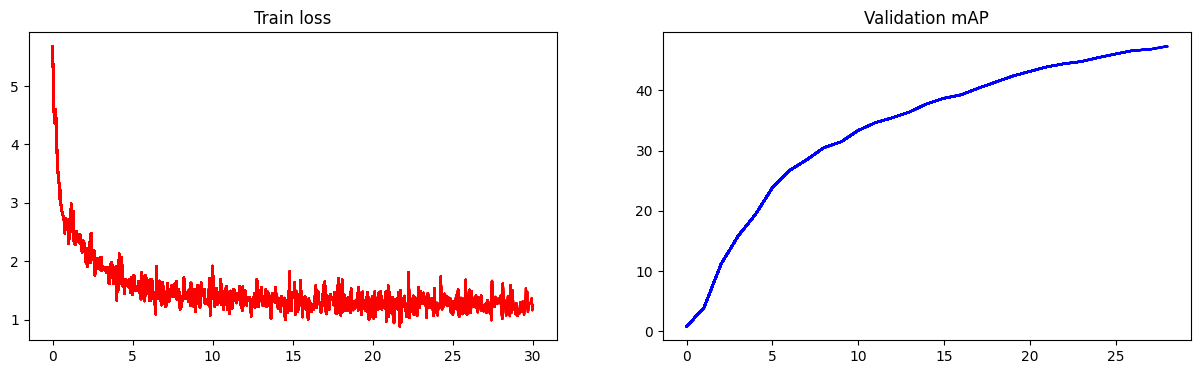

  0%|          | 0/25 [00:00<?, ?it/s]

(100, 448, 448)
(35, 448, 448)


  0%|          | 0/25 [00:00<?, ?it/s]

(63, 448, 448)
(67, 448, 448)


  0%|          | 0/25 [00:00<?, ?it/s]

(93, 448, 448)
(85, 448, 448)


  0%|          | 0/25 [00:00<?, ?it/s]

(100, 448, 448)
(93, 448, 448)


  0%|          | 0/25 [00:00<?, ?it/s]

(57, 448, 448)
(61, 448, 448)


  0%|          | 0/25 [00:00<?, ?it/s]

(100, 448, 448)
(99, 448, 448)


  0%|          | 0/25 [00:00<?, ?it/s]

(72, 448, 448)
(97, 448, 448)


  0%|          | 0/25 [00:00<?, ?it/s]

(59, 448, 448)
(72, 448, 448)


  0%|          | 0/25 [00:00<?, ?it/s]

(24, 448, 448)
(16, 448, 448)


  0%|          | 0/25 [00:00<?, ?it/s]

(69, 448, 448)
(73, 448, 448)


  0%|          | 0/25 [00:00<?, ?it/s]

(84, 448, 448)
(81, 448, 448)


  0%|          | 0/25 [00:00<?, ?it/s]

(46, 448, 448)
(47, 448, 448)


  0%|          | 0/25 [00:00<?, ?it/s]

(15, 448, 448)
(10, 448, 448)


  0%|          | 0/25 [00:00<?, ?it/s]

(92, 448, 448)
(87, 448, 448)


  0%|          | 0/25 [00:00<?, ?it/s]

(78, 448, 448)
(64, 448, 448)


  0%|          | 0/25 [00:00<?, ?it/s]

(39, 448, 448)
(44, 448, 448)


  0%|          | 0/25 [00:00<?, ?it/s]

(29, 448, 448)
(10, 448, 448)


  0%|          | 0/25 [00:00<?, ?it/s]

(63, 448, 448)
(60, 448, 448)


  0%|          | 0/25 [00:00<?, ?it/s]

(57, 448, 448)
(56, 448, 448)


  0%|          | 0/25 [00:00<?, ?it/s]

(96, 448, 448)
(89, 448, 448)


  0%|          | 0/25 [00:00<?, ?it/s]

(60, 448, 448)
(67, 448, 448)


  0%|          | 0/25 [00:00<?, ?it/s]

(49, 448, 448)
(52, 448, 448)


  0%|          | 0/25 [00:00<?, ?it/s]

(90, 448, 448)
(84, 448, 448)


  0%|          | 0/25 [00:00<?, ?it/s]

(20, 448, 448)
(15, 448, 448)


  0%|          | 0/25 [00:00<?, ?it/s]

(74, 448, 448)
(67, 448, 448)


  0%|          | 0/25 [00:00<?, ?it/s]

(67, 448, 448)
(74, 448, 448)


  0%|          | 0/25 [00:00<?, ?it/s]

(76, 448, 448)
(77, 448, 448)


  0%|          | 0/25 [00:00<?, ?it/s]

(39, 448, 448)
(41, 448, 448)


  0%|          | 0/25 [00:00<?, ?it/s]

(79, 448, 448)
(82, 448, 448)


  0%|          | 0/25 [00:00<?, ?it/s]

(57, 448, 448)
(55, 448, 448)


In [ ]:
trainer = trainer.cuda()
trainer.train(NUM_EPOCHS)

In [ ]:
trainer.calc_metric(test_loader)

  0%|          | 0/12 [00:00<?, ?it/s]

49.34217135111491